# Overview


This notebook is created for solving the [Kaggle House Price Modeling Challenge](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). The dataset has various categorical (nominal, binary, and ordinal variables) and numerical variables to determine the selling price of a house. The training dataset is rather small (1460) and it has a lot of variables (81). The lack of data and the huge number of variables was a pretty big challenge in this competition.

This notebook is my first base model to solving the problem. I perform a bit of EDA (exploratory data analysis) and I cycle through several models such as Linear Regression all the way to Xgboost and I also use a bit of model stacking to optimize model performance. 



## Table of Contents

1. [Utility Functions](#utility)
2. [Handling Missing Values](#missing_values)
3. [Understanding Target Variable](#target)
4. [Modeling](#modeling)

In [27]:
import sys
 
sys.path.append('C:\\Users\\Nikhil\\Data_Science_Projects')
from common_ds_modules import missing_values, data_manipulation, modeling
import os
import pandas as pd
import numpy as np
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

### Utility Functions <a id='utility'></a>

In [28]:
def get_column(df, query=''):
    for c in df.columns:
        if query.lower() in c.lower():
            print(f'Column: {c}')

In [29]:
MAX_MODELS = 100

In [30]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [31]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(lambda x: str(x))
test_df['MSSubClass'] = test_df['MSSubClass'].apply(lambda x: str(x))
train_df['LogSalePrice'] = np.log(train_df['SalePrice'] + 1)


### Fill in Missing Values <a id='missing_values'></a>

In [33]:
rename_columns = {'1stFlrSF': 'FirstFlrSF', '2ndFlrSF':'SecondFlrSF', '3SsnPorch':'ThreeSeasonPorch'} 
    

train_df = train_df.rename(rename_columns, axis='columns')
test_df = test_df.rename(rename_columns, axis='columns')

Getting rid of all columns that have more than 30% missing values. I chose 30 as a rather arbitrary number, I thought it was just right, if it is more than 30, then you will corrupt the variable distribution with the fill in value. 

For categorical variables I fill in missing values by using the mode, and for numerical variables I use the mean.

In [34]:
train_drop = missing_values.get_high_missing_value_columns(train_df, 30)
test_drop = missing_values.get_high_missing_value_columns(test_df, 30)


train_low_missing_vals_df = train_df.drop(train_drop, axis='columns')
test_low_missing_vals_df = test_df.drop(test_drop, axis='columns')

This function gets the numerical and categorical variables, and fills in missing values as well.

In [35]:
numerical_variables, categorical_variables = data_manipulation.get_numerical_categorical_variables(train_low_missing_vals_df,\
                                                                                            test_low_missing_vals_df, 'Id')
                                                                                                   

Sanity check to make sure that training and testing dataset don't have any columns with missing values after fill in.

In [36]:
missing_values.get_null_columns(train_low_missing_vals_df)
missing_values.get_null_columns(test_low_missing_vals_df)

In [37]:
def plot_variable_dist(df, variables):
    for c in variables:
        plt.hist(train_df[c])
        plt.title(f'Distribution for {c}')
        plt.show()

## Understanding the target variable <a id='target'></a>

For this problem I am trying to predict the SalePrice, so that is the target. In this section I will create a few plots to examine the SalePrice variable

In [38]:
target = 'SalePrice'

C:\Users\Nikhil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


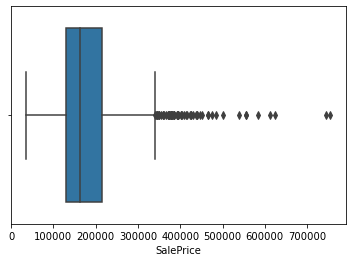

In [39]:
sns.boxplot(train_df[target])
plt.show()

In [40]:
q1 = np.percentile(train_df[target], 25)
q3 = np.percentile(train_df[target], 75)
iqr = q3 - q1
max_outlier = q3+1.5*iqr
print(f'Max outlier: {max_outlier}')
num_outliers = train_df[train_df['SalePrice'] > max_outlier].shape[0]
print(f'Percentage of outliers: {100*round(num_outliers/train_df.shape[0], 2)}')

Max outlier: 340037.5
Percentage of outliers: 4.0


#### Histogram of Sale Price

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <BarContainer object of 10 artists>)

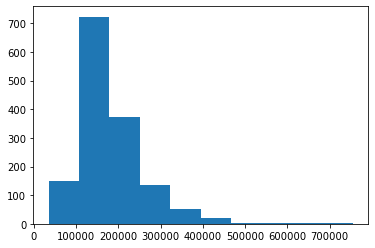

In [41]:
plt.hist(train_df['SalePrice'])

In [42]:
label = 'SalePrice'

### Correlation Matrix for all numerical variables

In [43]:
corr = train_df.corr()[label].sort_values()
valid_correlations = corr[(corr > 0.4) & (corr < 1)].index.tolist()
train_df[valid_correlations].corr()

,Fireplaces,MasVnrArea,GarageYrBlt,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,FirstFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,LogSalePrice
Fireplaces,1.000000,0.249070,0.046822,0.112581,0.147716,0.326114,0.243671,0.410531,0.339519,0.269141,0.300789,0.461679,0.396765,0.489450
MasVnrArea,0.249070,1.000000,0.252691,0.179618,0.315707,0.280682,0.276833,0.344501,0.363936,0.373066,0.364204,0.390857,0.411876,0.430809
GarageYrBlt,0.046822,0.252691,1.000000,0.642277,0.825667,0.148112,0.484557,0.233449,0.322445,0.564567,0.588920,0.231197,0.547766,0.541073
YearRemodAdd,0.112581,0.179618,0.642277,1.000000,0.592855,0.191740,0.439046,0.240379,0.291066,0.371600,0.420622,0.287389,0.550684,0.565608
YearBuilt,0.147716,0.315707,0.825667,0.592855,1.000000,0.095589,0.468271,0.281986,0.391452,0.478954,0.537850,0.199010,0.572323,0.586570
TotRmsAbvGrd,0.326114,0.280682,0.148112,0.191740,0.095589,1.000000,0.554784,0.409516,0.285573,0.337822,0.362289,0.825489,0.427452,0.534422
FullBath,0.243671,0.276833,0.484557,0.439046,0.468271,0.554784,1.000000,0.380637,0.323722,0.405656,0.469672,0.630012,0.550600,0.594771
FirstFlrSF,0.410531,0.344501,0.233449,0.240379,0.281986,0.409516,0.380637,1.000000,0.819530,0.489782,0.439317,0.566024,0.476224,0.596981
TotalBsmtSF,0.339519,0.363936,0.322445,0.291066,0.391452,0.285573,0.323722,0.819530,1.000000,0.486665,0.434585,0.454868,0.537808,0.612134
GarageArea,0.269141,0.373066,0.564567,0.371600,0.478954,0.337822,0.405656,0.489782,0.486665,1.000000,0.882475,0.468997,0.562022,0.650888


In [44]:
# compartmentalize in another program

In [45]:
y_train = train_low_missing_vals_df['LogSalePrice']
train_model_data, test_model_data = data_manipulation.get_train_test_model_data(train_low_missing_vals_df, test_low_missing_vals_df,\
                                                                                numerical_variables, categorical_variables,\
                                                                                'SalePrice', target2='LogSalePrice')

train_drop_columns = list(set(train_model_data.columns) - set(test_model_data.columns))
train_model_data_final = train_model_data.drop(train_drop_columns, axis='columns')

## Modeling <a id='modeling'></a>

### Default random forest regressor

In [46]:
import pickle

In [47]:
%%time
rf_model_default = RandomForestRegressor().fit(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train, rf_model_default)
filename = 'rf_default_model.pkl'
pickle.dump(rf_model_default, open(filename, 'wb'))


mean RMSLE = 0.14209999066690118, std RMSLE = 0.00972142378293112
CPU times: total: 24 s
Wall time: 33.7 s


In [48]:
#modeling section in new program

### RandomForest Regressor

In [49]:
%%time
rf_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[2,3],
    'min_samples_split':[20, 30],
    'min_samples_leaf':[20, 30]
}

rf_model = modeling.get_random_forest_regressor_results(train_model_data_final, y_train, param_grid=rf_param_grid, test=None, y_test=None)

model = RandomForestRegressor(**rf_model.best_params_).fit(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train,model)

C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


mean RMSLE = 0.19647765698202765, std RMSLE = 0.006551179403259499
CPU times: total: 35.2 s
Wall time: 44.5 s


### Decision Tree

In [50]:
%%time

dt_param_grid = {
    'max_depth':[2,3],
    'min_samples_split':[50, 30],
    'min_samples_leaf':[50, 30],
    'max_features' : [30, 40],
    'min_impurity_decrease': [i/100 for i in range(1, 3)],
    'ccp_alpha': [i/10 for i in range(1, 3)]
}

dt_model = modeling.get_decision_tree_model(train_model_data_final, y_train, dt_param_grid)
modeling.evaluate(train_model_data_final, y_train, dt_model)

C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Nikhil\anaconda3\lib\site-p

mean RMSLE = 0.3992256860383698, std RMSLE = 0.015929916505866743
CPU times: total: 38.9 s
Wall time: 50.6 s


###  XGBRegressor

In [51]:
%%time

xgb_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[2,3],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(1, 3)],
    'min_child_weight': [10*i for i in range(1,3)],
    'learning_rate': [i/100 for i in range(1,3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)

xgb_regressor = XGBRegressor(**xgb_model.best_params_)
scores = cross_val_score(xgb_regressor, train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f'mean RMSLE = {-np.mean(scores)}, std RMSLE = {np.std(scores)}')

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

xgb_regressor = XGBRegressor(**xgb_model.best_params_).fit(train_model_data_final, y_train)
train_pred = xgb_regressor.predict(train_model_data_final)
train_pred = np.exp(train_pred) - 1
print(f'MAE = {mean_absolute_error(train_df["SalePrice"], train_pred)}')
print(f'RMSLE = {np.sqrt(mean_squared_error(train_df["SalePrice"], train_pred))}')
test_pred = xgb_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
test_df[['Id', 'PredictedSalePrice']].to_csv('xgb_predicted.csv', index=False)

mean RMSLE = 5.142351050249056, std RMSLE = 0.01570371335182782
mean RMSLE = 5.1422521013551625, std RMSLE = 0.01544287904286843
MAE = 179928.26673997854
RMSLE = 196612.05255440506
CPU times: total: 1h 4min 4s
Wall time: 12min 37s


### Linear Regression

In [52]:
lr_model = modeling.get_linear_regressor_model(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train, lr_model)

mean RMSLE = 0.17140003259393077, std RMSLE = 0.027991473177328228


### Lasso Regression

In [53]:
%%time
lasso_param_grid = {
    'alpha':[i/100 for i in range(1, 3)]
}
lasso_gs = modeling.get_lasso_regression_model(train_model_data_final, y_train, lasso_param_grid)
lasso = Lasso(**lasso_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
scores = cross_val_score(lasso, scaler.transform(train_model_data_final), y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f'mean RMSLE = {-np.mean(scores)}')

mean RMSLE = 0.14418176386928863
CPU times: total: 656 ms
Wall time: 408 ms


### Elastic Net Regression

In [54]:
%%time
elastic_net_param_grid = {
    'alpha': [100*i for i in range(1,11)] + [i/100 for i in range(1,3)],
    'l1_ratio':[i/100 for i in range(1,3)]
}

elastic_net_model = modeling.get_elastic_net_regressor_model(train_model_data_final, y_train, elastic_net_param_grid)
best_elastic_net_model = ElasticNet(**elastic_net_model.best_params_)
modeling.evaluate(StandardScaler().fit_transform(train_model_data_final), y_train, best_elastic_net_model)

mean RMSLE = 0.15132605569444632, std RMSLE = 0.02434875878994365
CPU times: total: 7.61 s
Wall time: 3.16 s


In [55]:
elastic_net_model.best_params_

{'alpha': 0.02, 'l1_ratio': 0.02}

In [56]:
#el_net = ElasticNet(**elastic_net_model.best_params_)
scores = cross_val_score(best_elastic_net_model, StandardScaler().fit_transform(train_model_data_final), y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f'mean RMSLE = {-np.mean(scores)}')

mean RMSLE = 0.15132605569444632


### KNN Regressor

In [57]:
%%time

knn_param_grid = {
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['brute', 'ball_tree', 'kd_tree'],
    'n_neighbors' : [10*i for i in range(1,3)],
    'leaf_size': [10*i for i in range(1,3)],
    'p': [i for i in range(1,3)],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
modeling.evaluate(train_model_data_final, y_train, knn_regressor)

C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


mean RMSLE = 0.20376538868577163, std RMSLE = 0.006544415044060678
CPU times: total: 1min 8s
Wall time: 47.6 s


### Stacking Regressor with Lasso, Ridge, Elastic, Random Forest, and XGBRegressor as the final estimator

In [58]:
estimators = [
     ('KNN', KNeighborsRegressor(**knn_grid_search.best_params_)),
    ('Lasso', Lasso(**lasso_gs.best_params_)),
    ('Ridge', Ridge(alpha=580)),
    ('Elastic', ElasticNet(**elastic_net_model.best_params_)),
    ('RandomForestRegressor', RandomForestRegressor())
]

final_estimator=XGBRegressor(**xgb_model.best_params_)

stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)

modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+00, tolerance: 1.509e-02
  model = cd_fast.enet_coordinate_descent(


mean RMSLE = 5.141168118210303, std RMSLE = 0.011603195447551994


In [59]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
test_df[['Id', 'PredictedSalePrice']].to_csv('stacking_stacking_regressorressor_xgb_predicted.csv', index=False)

CPU times: total: 30.6 s
Wall time: 35.9 s


In [60]:
%%time
estimators = [
     ('KNN', KNeighborsRegressor(**knn_grid_search.best_params_)),
    ('Lasso', Lasso(**lasso_gs.best_params_)),
    ('Ridge', Ridge(alpha=580)),
    ('Elastic', ElasticNet(**elastic_net_model.best_params_)),
    ('XGBRegressor', XGBRegressor(**xgb_model.best_params_))
]



final_estimator=RandomForestRegressor()

stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)

modeling.evaluate(train_model_data_final, y_train, stacking_regressor)



C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+00, tolerance: 1.509e-02
  model = cd_fast.enet_coordinate_descent(


mean RMSLE = 0.1300674332791923, std RMSLE = 0.010709599685574183
CPU times: total: 1min 24s
Wall time: 22 s


In [61]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
test_df[['Id', 'PredictedSalePrice']].to_csv('stacking_regressor_rf.csv', index=False)

CPU times: total: 17.3 s
Wall time: 5.17 s


Both stacking regressors have far lower RMSLE's than the other models, it just goes to show you how powerful stacking is 